In [192]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from stable_baselines3.common.env_util import make_vec_env
from matplotlib import pyplot as plt
%matplotlib inline

from agents import A2CAgent, RandomAgent, SimpleAgent, SimpleAgentBetter, DQNAgent, PPOAgent  # noqa
from env import TrafficLightEnv
from util import ALL_LIGHTS_OFF, LEFT_LIGHT_ON, RIGHT_LIGHT_ON


In [193]:
# Init
env_params = {}
env = TrafficLightEnv(**env_params)
agent = A2CAgent(env, 20_000)
vec_env = make_vec_env(TrafficLightEnv, n_envs=1, env_kwargs=env_params, seed=123)


In [194]:
# Train
agent.train()

Agent training...


In [195]:
# Reset
obs = vec_env.reset()

In [196]:
# Run
print("---------------------------")
print("Step #0")
vec_env.render()
print()

max_steps = 20000
cars = []
actions = []
new_cars = []
passing = []
total_reward = 0
for step in range(max_steps):
    # Get action
    action = agent.get_action(obs)  # type: ignore
    actions.append(action[0])

    # Get env response
    obs, reward, done, info = vec_env.step(action)
    new_cars.append(info[0]["new_left"] + info[0]["new_right"])
    passing.append(max(info[0]["passed_left"], info[0]["passed_right"]))
    total_reward += reward

    # Check if done
    if done:
        print(f"Response: done={done}, info={info}")
        print(f"Done after {step} steps")
        success = not info[0]["TimeLimit.truncated"]
        print(f"Successful termination (no cars left): {success}")
        break
    
    # Only append cars afterwards, due to final observation
    cars.append((obs[0][0], obs[0][1]))

    # Print
    if step % 100 == 0:
        print(f"Step #{step + 1}")
        print("Action:", action)
        print(f"Response: obs={obs}, reward={reward}, done={done}, info={info}")
        print("State:  ", end="")
        vec_env.render()
        print()


print(f"Total Reward: {total_reward}")

---------------------------
Step #0
1 -> |    | <- 1

Step #1
Action: [1]
Response: obs=[[3. 1.]], reward=[1.], done=[False], info=[{'passed_left': 1, 'passed_right': 0, 'new_left': 3, 'new_right': 0, 'TimeLimit.truncated': False}]
State:  3 -> |    | <- 1

Step #101
Action: [1]
Response: obs=[[2. 7.]], reward=[3.], done=[False], info=[{'passed_left': 3, 'passed_right': 0, 'new_left': 0, 'new_right': 2, 'TimeLimit.truncated': False}]
State:  2 -> |    | <- 7

Step #201
Action: [1]
Response: obs=[[1. 4.]], reward=[3.], done=[False], info=[{'passed_left': 3, 'passed_right': 0, 'new_left': 0, 'new_right': 1, 'TimeLimit.truncated': False}]
State:  1 -> |    | <- 4

Step #301
Action: [1]
Response: obs=[[8. 7.]], reward=[2.], done=[False], info=[{'passed_left': 2, 'passed_right': 0, 'new_left': 3, 'new_right': 0, 'TimeLimit.truncated': False}]
State:  8 -> |    | <- 7

Step #401
Action: [2]
Response: obs=[[8. 8.]], reward=[4.], done=[False], info=[{'passed_left': 0, 'passed_right': 4, 'new_l

In [197]:
# Format plot data
if step + 1 < max_steps:
    obs = info[0]["terminal_observation"]
    cars.append((obs[0], obs[1]))

max_cars = max(map(max, cars))
cars_left, cars_total = map(list, zip(*((-l, l+r) for l, r in cars)))

ACTION_MAP = {ALL_LIGHTS_OFF: 0, LEFT_LIGHT_ON: -max_cars -1, RIGHT_LIGHT_ON: max_cars + 1}
actions = [ACTION_MAP[a] for a in actions]

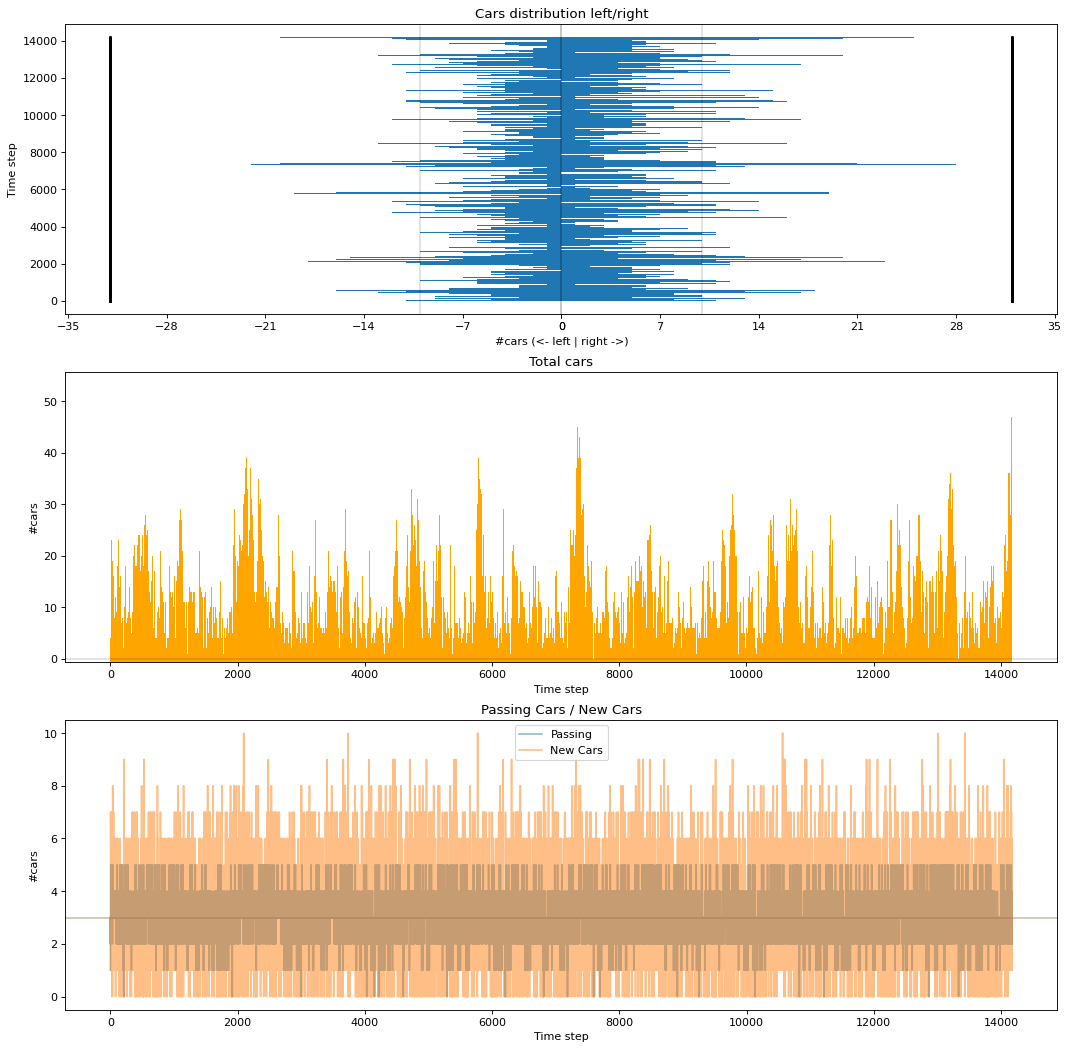

In [198]:
# Plot
figure, axis = plt.subplots(3, figsize=(16, 16), dpi=80)


# axis[0].fill_betweenx(list(range(len(cars))), cars_left, cars_right) 
axis[0].barh(y=list(range(len(cars))), width=cars_total, height=1, left=cars_left)

axis[0].scatter(actions, list(range(len(actions))), s=1.5, c="black")  # action taken
axis[0].axvline(0, c="black", linewidth=0.4)
axis[0].axvline(-10, c="black", linewidth=0.2)
axis[0].axvline(10, c="black", linewidth=0.2)

ticks = list(range(0, int(max_cars * 1.2) + 1, max(int(max_cars * 1.2) // 5, 1)))
ticks = [-t for t in reversed(ticks)] + ticks
axis[0].set_xticks(ticks)
axis[0].set_title("Cars distribution left/right")
axis[0].set_ylabel("Time step")
axis[0].set_xlabel("#cars (<- left | right ->)")


axis[1].set_title("Total cars")
axis[1].set_xlabel("Time step")
axis[1].set_ylabel("#cars")
cars_total_bar = [c + max_cars/50 for c in cars_total]
axis[1].bar(list(range(len(cars_total))), cars_total_bar, width=1.0, bottom=-max_cars/50, color="orange")
axis[1].axhline(0, c="black", linewidth=0.2)

axis[2].set_title("Passing Cars / New Cars")
axis[2].set_xlabel("Time step")
axis[2].set_ylabel("#cars")
p1 = axis[2].plot(list(range(len(passing))), passing, alpha=0.5, label="Passing") 
p2 = axis[2].plot(list(range(len(new_cars))), new_cars, alpha=0.5, label="New Cars") 
axis[2].axhline(np.average(passing), alpha=1, c=p1[0].get_color(), linewidth=0.4)
axis[2].axhline(np.average(new_cars), alpha=1, c=p2[0].get_color(), linewidth=0.4)
axis[2].legend()

plt.show()